In [2]:
# install all the necessary packages
import warnings
warnings.filterwarnings('ignore')


# import all the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

# down the necessary packages
# nltk.download("punkt")
# nltk.download("stopwords")

import nltk.data
from nltk import word_tokenize,sent_tokenize

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
import string
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


In [3]:
# get the data set
data=pd.read_csv("C:\\Users\\frodo\\Desktop\\stat578\\newfinalp\\dataset.csv", header=0, sep=",",quoting=0, encoding = "ISO-8859-1")
data.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


In [3]:
def review_to_wordlist(review):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    # 2. Remove non-letters(To remove punctuation and numbers)
    review_text = re.sub("[^a-zA-Z]"," ", review_text) 
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. remove stop words
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    # 5. stem
    stemmer=PorterStemmer()
    stems=map(stemmer.stem,words)
    # 6. Return a list of words
#     return(words)
    return( " ".join(stems))

In [5]:
clean_train_reviews = list(map(review_to_wordlist, data["SentimentText"]))

In [5]:
data.iloc[0,0]
clean_train_reviews[0]

"first think another Disney movie, might good, it's kids movie. watch it, can't help enjoy it. ages love movie. first saw movie 10 8 years later still love it! Danny Glover superb could play part better. Christopher Lloyd hilarious perfect part. Tony Danza believable Mel Clark. can't help, enjoy movie! give 10/10!"

# SEPERATE TRAIN AND TEST SET

In [7]:
# prepare for the training and testing data
# split the labeled data into train and test data
train_y=np.array(data["Sentiment"])
x_train, x_test, y_train, y_test =train_test_split(clean_train_reviews, train_y, test_size=0.25, random_state=42)

# SGD MODEL

In [8]:
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3),max_df=0.95,min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

# fit the model
text_clf.fit(x_train, y_train)
# make prediction
pred_sgd = text_clf.predict(x_test)

In [9]:
f1_score(y_test, pred_sgd)

0.8795844482921455

# MODEL HYPTERPARAMETER TUNING

Parameter tuning using grid search

In [10]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, iid=False, n_jobs=-1)
gs_clf = gs_clf.fit(x_train, y_train)
gs_clf.best_score_                                  

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


# Naive bayse model

In [11]:
text_clf2 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3),max_df=0.95,min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
]) 

In [12]:
# fit the model
text_clf2.fit(x_train, y_train)
# make prediction
pred_nb=text_clf2.predict(x_test)
f1_score(y_test, pred_nb)

0.8850174216027875

# Logistic regression model

In [13]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

In [14]:
lreg = LogisticRegression()
lreg.fit(x_train, y_train) # training the model
score = lreg.score(x_test, y_test)
print("Accuracy:", score)

Accuracy: 0.87536


# Word Embeddings

In [15]:
sentences_train, sentences_test, y_train, y_test = train_test_split(data["SentimentText"],data["Sentiment"], test_size=0.25, random_state=42)


tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

x_train2 = tokenizer.texts_to_sequences(sentences_train)
x_test2 = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(x_train2[2])

[215, 443, 59, 68, 135, 1124, 3606, 1431, 484, 2415, 262, 481, 1145, 4968, 1832, 424, 2, 100, 435, 2871, 4517, 135, 454, 443, 406, 135, 407, 2574, 3460, 2155, 2974, 4968, 3234, 1228, 835, 2588, 155, 74, 1055, 1157, 1654, 130, 288, 1650, 146, 3936, 2343, 21, 3382, 3895, 2787, 3657, 8, 1285, 4193, 306, 778, 11, 988, 1679, 8, 687, 454, 3258, 1, 1, 2330, 3, 158, 2155, 2575, 2759, 4479, 186, 6, 740, 15, 382, 1748, 656, 4322, 3489, 2975, 1568, 557, 404, 2259, 53, 631, 3896, 3061, 2588, 2172, 4285, 1106, 684, 416, 361, 324, 2588, 1751, 2648, 709, 396, 1768, 155, 74, 1, 1, 158, 367, 2872, 1172, 87, 3, 459, 281, 269, 124, 67, 1426, 3, 17, 145, 6, 190, 209, 158, 16, 79, 1230, 1381, 991, 61, 766, 557, 2480, 37, 50, 414, 64, 156, 424, 100, 1322, 83, 1512, 1452, 3516, 3337, 557, 966, 53, 4194, 25, 1536, 340, 1568, 192, 102, 4802, 2069, 38, 146, 601, 51, 1811, 3, 153, 710, 2432, 735, 62, 1375, 377, 3936, 1457]


In [16]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 8
all: 78
happy: 629
sad: 553


In [18]:
max_features = 5000
maxlen = 400
batch_size = 64
embedding_dims = 50
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 4

In [19]:
x_train2 = sequence.pad_sequences(x_train2, maxlen=maxlen)
x_test2 = sequence.pad_sequences(x_test2, maxlen=maxlen)
print('x_train2 shape:', x_train2.shape)
print('x_test2 shape:', x_test2.shape)

x_train2 shape: (18750, 400)
x_test2 shape: (6250, 400)


In [20]:
model = Sequential()

model.add(Embedding(max_features, embedding_dims, input_length=maxlen, dropout=0.2))

model.add(
    Convolution1D(
        nb_filter=nb_filter,
        filter_length=filter_length,
        border_mode='valid',
        activation='relu',
        subsample_length=1,
    )
)

model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
__________

In [23]:
h = model.fit(
    x_train2,
    y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_data=(x_test2, y_test),
    verbose=1,
)

Train on 18750 samples, validate on 6250 samples
Epoch 1/4
18750/18750 [==============================] - 109s 6ms/step - loss: 0.4495 - acc: 0.7662 - val_loss: 0.3077 - val_acc: 0.8662
Epoch 2/4
18750/18750 [==============================] - 108s 6ms/step - loss: 0.2248 - acc: 0.9119 - val_loss: 0.3178 - val_acc: 0.8680
Epoch 3/4
18750/18750 [==============================] - 108s 6ms/step - loss: 0.1144 - acc: 0.9624 - val_loss: 0.3284 - val_acc: 0.8733
Epoch 4/4
18750/18750 [==============================] - 108s 6ms/step - loss: 0.0421 - acc: 0.9894 - val_loss: 0.4339 - val_acc: 0.8648


In [24]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

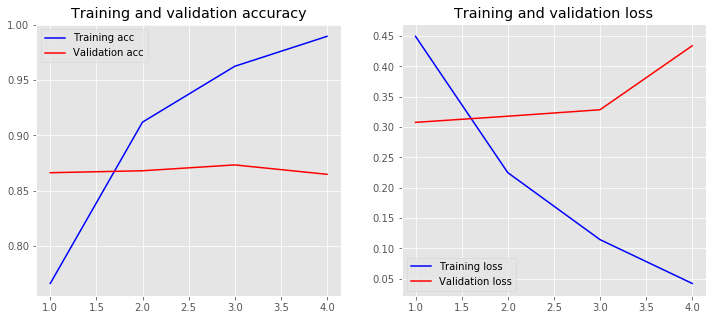

In [25]:
plot_history(h)

In [26]:
loss, accuracy = model.evaluate(x_train2, y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.997600  ;  loss = 0.016817


In [27]:
loss, accuracy = model.evaluate(x_test2, y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Validation: accuracy1 = 0.864800  ;  loss1 = 0.433946


Convolutional Neural Networks (CNN)

Using Pretrained Word Embeddings-GloVe and 1-D CNN

In [28]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [29]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'C:\\Users\\frodo\\Desktop\\stat578\\glove.6B\\glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [30]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7051326524057301

In [31]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 50)           3891750   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 396, 128)          32128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 3,925,179
Trainable params: 3,925,179
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9851
Testing Accuracy:  0.8730


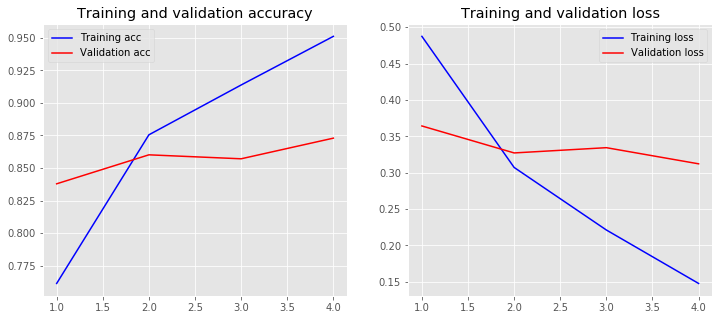

In [32]:
history = model.fit(x_train2, y_train,
                    epochs=4,
                    verbose=False,
                    validation_data=(x_test2, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(x_train2, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test2, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Hyperparameters Optimization

In [33]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim,  weights=[embedding_matrix], input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [34]:
# Main settings
epochs = 4
embedding_dim = 50
maxlen = 400

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(x_train2, y_train)

# Evaluate testing set
test_accuracy = grid.score(x_test2, y_test)

In [35]:
output_file = 'C:\\Users\\frodo\\Desktop\\stat578\\newfinalp\\output.txt'

with open(output_file, 'a') as f:
    s = ('Best Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)

# Topic Modeling

In [36]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

In [38]:
# get the subset of the data set
sub_data = data.loc[1:100000, ["text", "stars"]]
freq_words(sub_data['text'])

In [39]:
# remove unwanted characters, numbers and symbols
sub_data['text'] = sub_data['text'].str.replace("[^a-zA-Z#]", " ")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
sub_data['text'] = sub_data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in sub_data['text']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

text = " ".join(review for review in sub_data.text)
print ("There are {} words in the combination of all review.".format(len(text)))
# Create stopword list:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
freq_words(reviews, 25)

In [41]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

sub_data['text'] = reviews_3

freq_words(sub_data['text'], 25)

dictionary = corpora.Dictionary(reviews_2)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [42]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

lda_model.print_topics()

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

In [43]:
lda_model.print_topics()

In [44]:
p = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(p, 'lda.html')